# FAKE NEWS DETECTION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Reading Datasets

In [4]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [5]:
fake.shape

(23481, 4)

In [6]:
true.shape

(21417, 4)

# Data cleaning and preperation

In [7]:
# Adding flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [8]:
# Concatenating dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [9]:
# Shuffling the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [10]:
data.head()

,title,text,subject,date,target
0,Czech Babis gains possible support in bid for ...,PRAGUE (Reuters) - Czech billionaire Andrej Ba...,worldnews,"October 30, 2017",true
1,Oklahoma governor vetoes bill to jail abortion...,(Reuters) - Oklahoma’s Republican Governor Mar...,politicsNews,"May 20, 2016",true
2,Watch As The Right Changes History Before You...,The announcement that Harriet Tubman would rep...,News,"April 21, 2016",fake
3,Two Dead After Father-Son Shootout At Gun Store,An argument over a $25 gun repair charge led t...,News,"January 24, 2016",fake
4,THE BEST ANTI-HILLARY AD EVER MADE…You’ll Want...,The Ted Cruz campaign has identified the enemy...,politics,"Feb 12, 2016",fake


In [11]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Czech Babis gains possible support in bid for ...,PRAGUE (Reuters) - Czech billionaire Andrej Ba...,worldnews,true
1,Oklahoma governor vetoes bill to jail abortion...,(Reuters) - Oklahoma’s Republican Governor Mar...,politicsNews,true
2,Watch As The Right Changes History Before You...,The announcement that Harriet Tubman would rep...,News,fake
3,Two Dead After Father-Son Shootout At Gun Store,An argument over a $25 gun repair charge led t...,News,fake
4,THE BEST ANTI-HILLARY AD EVER MADE…You’ll Want...,The Ted Cruz campaign has identified the enemy...,politics,fake


In [12]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,PRAGUE (Reuters) - Czech billionaire Andrej Ba...,worldnews,true
1,(Reuters) - Oklahoma’s Republican Governor Mar...,politicsNews,true
2,The announcement that Harriet Tubman would rep...,News,fake
3,An argument over a $25 gun repair charge led t...,News,fake
4,The Ted Cruz campaign has identified the enemy...,politics,fake


In [13]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,prague (reuters) - czech billionaire andrej ba...,worldnews,true
1,(reuters) - oklahoma’s republican governor mar...,politicsNews,true
2,the announcement that harriet tubman would rep...,News,fake
3,an argument over a $25 gun repair charge led t...,News,fake
4,the ted cruz campaign has identified the enemy...,politics,fake


In [14]:
# Removing punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [15]:
data.head()

,text,subject,target
0,prague reuters czech billionaire andrej babis...,worldnews,true
1,reuters oklahoma’s republican governor mary f...,politicsNews,true
2,the announcement that harriet tubman would rep...,News,fake
3,an argument over a 25 gun repair charge led to...,News,fake
4,the ted cruz campaign has identified the enemy...,politics,fake


In [16]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pratik\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [17]:
data.head()

,text,subject,target
0,prague reuters czech billionaire andrej babis ...,worldnews,true
1,reuters oklahoma’s republican governor mary fa...,politicsNews,true
2,announcement harriet tubman would replace andr...,News,fake
3,argument 25 gun repair charge led fatherson sh...,News,fake
4,ted cruz campaign identified enemy placed targ...,politics,fake


# Data Exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


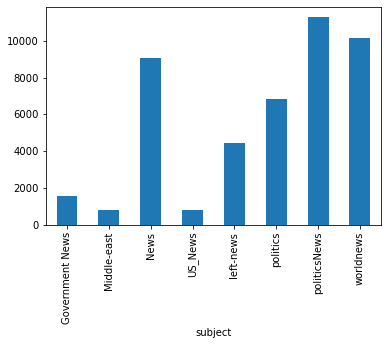

In [18]:
# Articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


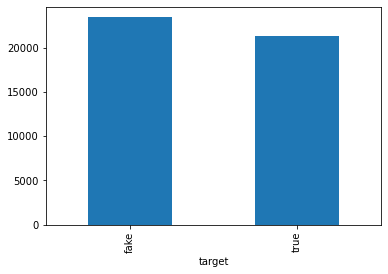

In [19]:
#  fake vs real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

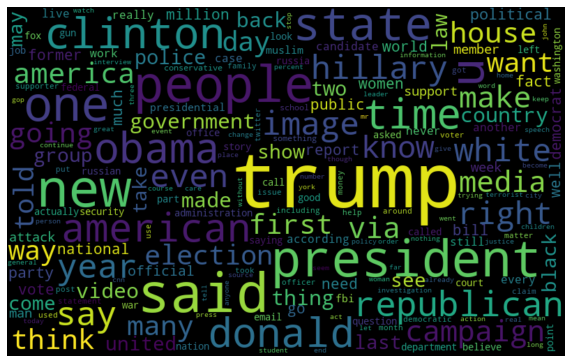

In [21]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

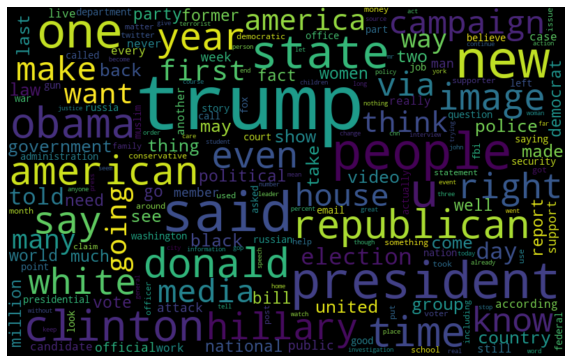

In [22]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
# Most frequent words counter    
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

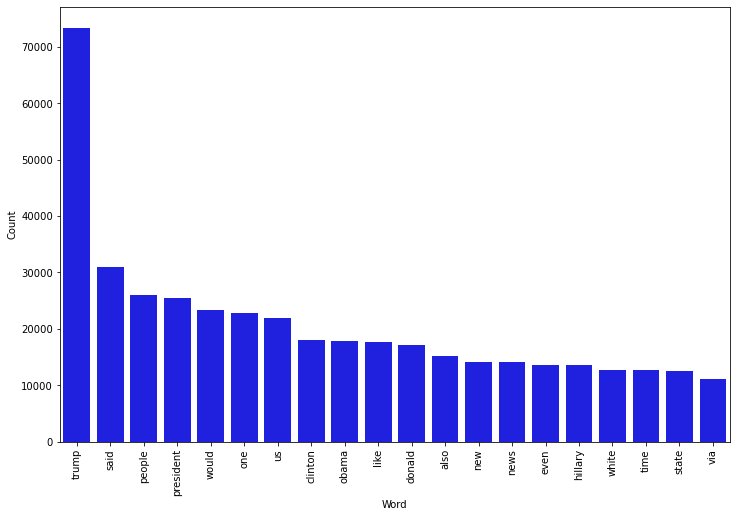

In [24]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

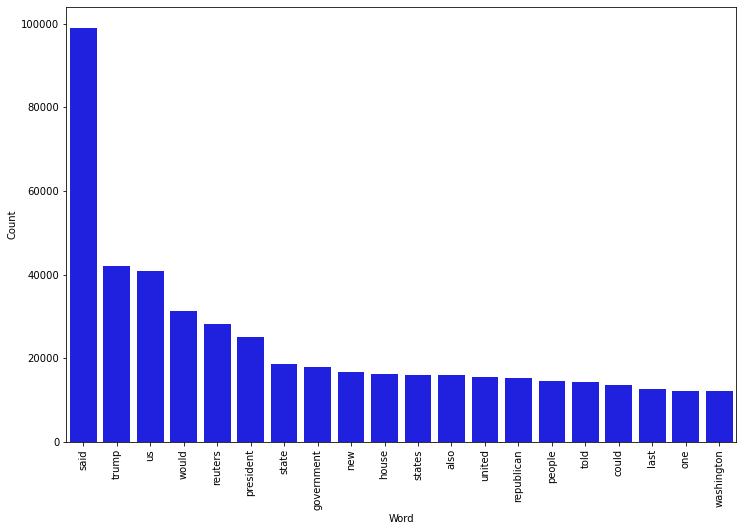

In [25]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

# Modeling

In [26]:
# Function to plot the confusion matrix 
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# preparing data

In [27]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# Logistic Regression

In [28]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.9%


Confusion matrix, without normalization


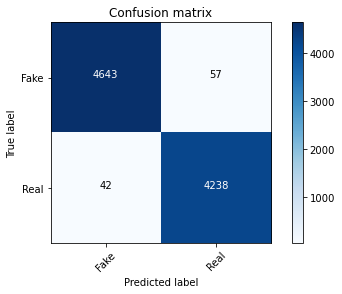

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Decision Tree Classifier

In [30]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.7%


Confusion matrix, without normalization


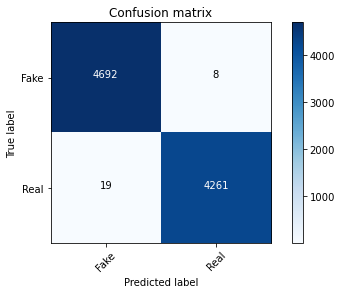

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Random forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.88%


Confusion matrix, without normalization


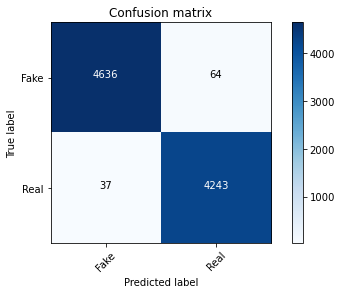

In [33]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])